This project was heavily inspired by "Maximizing Precision of Hit Predictions in Baseball" by Jason Clavelli and Joel Gottsegen

In [1]:
import pandas, numpy
import requests
import lxml
import bs4
#from lxml import html
from urllib import request, response, error, parse
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re, os

In [2]:
# Scraper from GitHub by Ben Kite, thank you so much

## This is the best place to get started.
## This function simply takes a url and provides the ids
## from the html tables that the code provided here can access.
## Using findTables is great for determining options for the
## pullTable function for the tableID argument.
def findTables(url):
    res = requests.get(url)
    ## The next two lines get around the issue with comments breaking the parsing.
    comm = re.compile("<!--|-->")
    soup = bs4.BeautifulSoup(comm.sub("", res.text), 'html')
    divs = soup.findAll('div', id = "content")
    divs = divs[0].findAll("div", id=re.compile("^all"))
    ids = []
    for div in divs:
        searchme = str(div.findAll("table"))
        x = searchme[searchme.find("id=") + 3: searchme.find(">")]
        x = x.replace("\"", "")
        if len(x) > 0:
            ids.append(x)
    return(ids)
## For example:
## findTables("http://www.baseball-reference.com/teams/KCR/2016.shtml")


## Pulls a single table from a url provided by the user.
## The desired table should be specified by tableID.
## This function is used in all functions that do more complicated pulls.
def pullTable(url, tableID):
    res = requests.get(url)
    ## Work around comments
    comm = re.compile("<!--|-->")
    soup = bs4.BeautifulSoup(comm.sub("", res.text), 'html')
    tables = soup.findAll('table', id = tableID)
    data_rows = tables[0].findAll('tr')
    data_header = tables[0].findAll('thead')
    data_header = data_header[0].findAll("tr")
    data_header = data_header[0].findAll("th")
    game_data = [[td.getText() for td in data_rows[i].findAll(['th','td'])]
        for i in range(len(data_rows))
        ]
    data = pandas.DataFrame(game_data)
    header = []
    for i in range(len(data.columns)):
        header.append(data_header[i].getText())
    data.columns = header
    data = data.loc[data[header[0]] != header[0]]
    data = data.reset_index(drop = True)
    return(data)
## For example:
## url = "http://www.baseball-reference.com/teams/KCR/2016.shtml"
## pullTable(url, "team_batting")



## Pulls game level data for team and year provided.
## The team provided must be a three-character abbreviation:
## 'ATL', 'ARI', 'BAL', 'BOS', 'CHC', 'CHW', 'CIN', 'CLE', 'COL', 'DET',
## 'KCR', 'HOU', 'LAA', 'LAD', 'MIA', 'MIL', 'MIN', 'NYM', 'NYY', 'OAK',
## 'PHI', 'PIT', 'SDP', 'SEA', 'SFG', 'STL', 'TBR', 'TEX', 'TOR', 'WSN'
def pullGameData (team, year):
    url = "http://www.baseball-reference.com/teams/" + team + "/" + str(year) + "-schedule-scores.shtml"
    ## Let's funnel this work into the pullTable function
    dat = pullTable(url, "team_schedule")
    dates = dat["Date"]
    ndates = []
    for d in dates:
        month = d.split(" ")[1]
        day = d.split(" ")[2]
        day = day.zfill(2)
        mapping = {"Mar": "03", "Apr": "04", "May": "05", "Jun": "06", "Jul": "07", "Aug": "08",
                   "Sep": "09", "Oct": "10", "Nov":"11"}
        m = mapping[month]
        ndates.append(str(year) + m + day)
    uni, counts = numpy.unique(ndates, return_counts = True)
    ndates = []
    for t in range(len(counts)):
        ux = uni[t]
        cx = counts[t]
        if cx == 1:
            ndates.append(ux + "0")
        else:
            for i in range(int(cx)):
                ii = i + 1
                ndates.append(ux + str(ii))
    dat["Date"] = ndates
    dat.rename(columns = {dat.columns[4] : "Location"}, inplace = True)
    homegame = []
    for g in dat["Location"]:
        homegame.append(g == "")
    dat["HomeGame"] = homegame
    return(dat)


## Pulls data summarizing the season performance of all players on the
## team provided for the given year.
## The table type argument must be one of five possibilities:
## "team_batting"
## "team_pitching"
## "standard_fielding"
## "players_value_batting"
## "players_value_pitching"
def pullPlayerData (team, year, tabletype):
    url = "http://www.baseball-reference.com/teams/" + team + "/" + str(year) + ".shtml"
    data = pullTable(url, tabletype)
    data = data[data.Name.notnull()]
    data = data.reset_index(drop = True)
    names = data.columns
    for c in range(0, len(names)):
        replacement = []
        if type (data.loc[0][c]) == str:
            k = names[c]
            for i in range(0, len(data[k])):
                p = data.loc[i][c]
                xx = re.sub("[#@*&^%$!]", "", p)
                xx = xx.replace("\xa0", "_")
                xx = xx.replace(" ", "_")
                replacement.append(xx)
            data[k] = replacement
    data["Team"] = team
    data["Year"] = year
    return(data)


## This is used later to append integers to games on the same date to
## separate them.
def Quantify (x):
    out = []
    for i in x:
        if len(i) < 1:
            out.append(None)
        else:
            out.append(float(i))
    return(out)


## Pulls box score data from a game provided in the gameInfo input
## This is meant to be run by the pullBoxScores function below.
def gameFinder (gameInfo):
    teamNames = {"KCR":"KCA",
                 "CHW":"CHA",
                 "CHC":"CHN",
                 "LAD":"LAN",
                 "NYM":"NYN",
                 "NYY":"NYA",
                 "SDP":"SDN",
                 "SFG":"SFN",
                 "STL":"SLN",
                 "TBR":"TBA",
                 "WSN":"WAS",
                 "LAA":"ANA"}
    battingNames = {"ATL":"AtlantaBravesbatting",
                    "ARI":"ArizonaDiamondbacksbatting",
                    "BAL":"BaltimoreOriolesbatting",
                    "BOS":"BostonRedSoxbatting",
                    "CHC":"ChicagoCubsbatting",
                    "CHW":"ChicagoWhiteSoxbatting",
                    "CIN":"CincinnatiRedsbatting",
                    "CLE":"ClevelandIndiansbatting",
                    "COL":"ColoradoRockiesbatting",
                    "DET":"DetroitTigersbatting",
                    "KCR":"KansasCityRoyalsbatting",
                    "HOU":"HoustonAstrosbatting",
                    "LAA":"AnaheimAngelsbatting",
                    "LAD":"LosAngelesDodgersbatting",
                    "MIA":"MiamiMarlinsbatting",
                    "MIL":"MilwaukeeBrewersbatting",
                    "MIN":"MinnesotaTwinsbatting",
                    "NYM":"NewYorkMetsbatting",
                    "NYY":"NewYorkYankeesbatting",
                    "OAK":"OaklandAthleticsbatting",
                    "PHI":"PhiladelphiaPhilliesbatting",
                    "PIT":"PittsburghPiratesbatting",
                    "SDP":"SanDiegoPadresbatting",
                    "SEA":"SeattleMarinersbatting",
                    "SFG":"SanFranciscoGiantsbatting",
                    "STL":"StLouisCardinalsbatting",
                    "TBR":"TampaBayRaysbatting",
                    "TEX":"TexasRangersbatting",
                    "TOR":"TorontoBlueJaysbatting",
                    "WSN":"WashingtonNationalsbatting"}
    date = gameInfo["Date"]
    home = gameInfo["HomeGame"]
    if home == False:
        opp = gameInfo["Opp"]
        if opp in teamNames:
            opp = teamNames[opp]
        url = "http://www.baseball-reference.com/boxes/" + opp + "/" + opp + str(date) + ".shtml"
    else:
        team = gameInfo["Tm"]
        if team in teamNames:
            team = teamNames[team]
        url = "http://www.baseball-reference.com/boxes/" + team + "/" + team + str(date) + ".shtml"
    battingInfo = battingNames[gameInfo["Tm"]]
    data = pullTable(url, battingInfo)
    names = []
    for i in data["Batting"]:
        if len(i) > 0:
            xx = (i.split(" ")[0] + "_" + i.split(" ")[1])
            xx = xx.replace("\xa0", "")
            names.append(xx)
        else:
            names.append("NA")
    data["Name"] = names
    data["Date"] = date
    data["HomeGame"] = home
    data = data[data.Name != "NA"]
    for d in data:
        if d not in ["Batting", "Name", "Details", "Date", "HomeGame"]:
            tmp = Quantify(data[d])
            data[d] = tmp
    data = data[data["AB"] > 0]
    return(data)


## Pulls all of the boxscores for a team in a given year.
## The directory argument is used to specify where to save the .csv
## If overwrite is True, an existing file with the same name will be overwritten.
def pullBoxscores (team, year, directory, overwrite = True):
    if not os.path.exists(directory):
        os.makedirs(directory)
    if overwrite == False:
        if os.path.exists(directory + team + ".csv"):
            return("This already exists!")
    dat = pullGameData(team, year)
    DatDict = dict()
    for r in range(len(dat)):
        inputs = dat.loc[r]
        try:
            DatDict[r] = gameFinder(inputs)
        except IndexError:
            pass
    playerGameData = pandas.concat(DatDict)
    playerGameData.reset_index(inplace = True)
    playerGameData = playerGameData.rename(columns = {"level_0": "Game", "level_1": "BatPos"})
    playerGameData.to_csv(directory + team + "_" + str(year) + ".csv")


## This is an internal function to pullPlaybyPlay
def PlayByPlay (gameInfo):
    teamNames = {"KCR":"KCA",
                 "CHW":"CHA",
                 "CHC":"CHN",
                 "LAD":"LAN",
                 "NYM":"NYN",
                 "NYY":"NYA",
                 "SDP":"SDN",
                 "SFG":"SFN",
                 "STL":"SLN",
                 "TBR":"TBA",
                 "WSN":"WAS",
                 "LAA":"ANA"}
    oteam = gameInfo["Tm"]
    date = gameInfo["Date"]
    home = gameInfo["HomeGame"]
    if home == 0:
        team = gameInfo["Opp"]
        opp = gameInfo["Tm"]
        if opp in teamNames:
            opp = teamNames[opp]
    else:
        team = gameInfo["Tm"]
        opp = gameInfo["Opp"]
        if team in teamNames:
            team = teamNames[team]
    url = "http://www.baseball-reference.com/boxes/" + team + "/" + team + str(date) + ".shtml"
    dat = pullTable(url, "play_by_play")
    dat = dat.loc[dat["Batter"].notnull()]
    dat = dat.loc[dat["Play Description"].notnull()]
    dat["Date"] = date
    dat["Hteam"] = team
    dat["Ateam"] = opp
    pteam = []
    pteams = numpy.unique(dat["@Bat"])
    for d in dat["@Bat"]:
        if d == pteams[0]:
            pteam.append(pteams[1])
        else:
            pteam.append(pteams[0])
    dat["Pteam"] = pteam
    if gameInfo["R"] > gameInfo["RA"]:
        winner = oteam
    else:
        winner = gameInfo["Opp"]
    dat["Winner"] = winner
    return(dat)


## Pulls all of the play by play tables for a team for a given year.
## Output is the name of the .csv file you want to save.  I force a
## file to be saved here because the function takes a while to run.
def pullPlaybyPlay (team, year, output, check = False):
    dat = pullGameData(team, year)
    dat = dat[dat.Time == dat.Time] ## Only pull games that have ended
    if check:
        olddat = pandas.read_csv(output)
        dates = numpy.unique(olddat.Date)
        mostrecent = numpy.max(dates)
        dat.Date = dat.Date.astype("int")
        dat = dat.loc[dat.Date > mostrecent]
        dat.reset_index(inplace = True)
        dat = dat.loc[dat.Time == dat.Time]
    DatDict = dict()
    for r in range(len(dat)):
        inputs = dat.loc[r]
        try:
            DatDict[r] = PlayByPlay(inputs)
        except IndexError:
            pass
    if len(DatDict) == 0:
        return("No new games to be added!")
    bdat = pandas.concat(DatDict)
    bdat["Hteam"] = team
    names = []
    for i in bdat["Batter"]:
        if len(i) > 0:
            xx = i
            xx = xx.replace("\xa0", "")
            names.append(xx)
        else:
            names.append("NA")
    bdat["BatterName"] = names
    ## These rules attempt to sort out different play outcomes by
    ## searching the text in the "Play Description" variable.
    bdat["out"] = (bdat["Play Description"].str.contains("out")) | (bdat["Play Description"].str.contains("Play")) | (bdat["Play Description"].str.contains("Flyball")) | (bdat["Play Description"].str.contains("Popfly"))
    bdat["hbp"] = bdat["Play Description"].str.startswith("Hit")
    bdat["walk"] = (bdat["Play Description"].str.contains("Walk"))
    bdat["stolenB"] = bdat["Play Description"].str.contains("Steal")
    bdat["wild"] = bdat["Play Description"].str.startswith("Wild") | bdat["Play Description"].str.contains("Passed")
    bdat["error"] = bdat["Play Description"].str.contains("Reached on")
    bdat["pick"] = bdat["Play Description"].str.contains("Picked")
    bdat["balk"] = bdat["Play Description"].str.contains("Balk")
    bdat["interference"] = bdat["Play Description"].str.contains("Reached on Interference")
    bdat["sacrifice"] = bdat["Play Description"].str.contains("Sacrifice")
    bdat["ab"] = (bdat["walk"] == False) & (bdat["sacrifice"] == False) & (bdat["interference"] == False) & (bdat["stolenB"] == False) & (bdat["wild"] == False) & (bdat["hbp"] == False) & (bdat["pick"] == False) & (bdat["balk"] == False)
    bdat["hit"] =  (bdat["walk"] == False) & (bdat["out"] == False) & (bdat["stolenB"] == False) & (bdat["error"] == False) & (bdat["ab"] == True)
    if check:
        if len(olddat) > 0:
            bdat = olddat.append(bdat)
            bdat.reset_index(inplace = True, drop = True)
    bdat.to_csv(output)
    return(bdat)


## This pulls information about which hand a pitcher throws with.  I
## made this solely to allow pitcher handedness to be used as a
## variable in models.
def pullPitcherData (team, year):
    url = "http://www.baseball-reference.com/teams/" + team + "/" + str(year) + ".shtml"
    data = pullTable(url, "team_pitching")
    data = data[data.Name.notnull()]
    data = data[data.Rk.notnull()]
    data = data[data.G != "162"]
    data = data.reset_index(drop = True)
    data["Team"] = team
    data["Year"] = year
    data["LeftHanded"] = data["Name"].str.contains("\\*")
    names = data.columns
    for c in range(0, len(names)):
        replacement = []
        if type (data.loc[0][c]) == str:
            k = names[c]
            for i in range(0, len(data[k])):
                p = data.loc[i][c]
                xx = re.sub("[#@&*^%$!]", "", p)
                xx = xx.replace("\xa0", "_")
                xx = xx.replace(" ", "_")
                replacement.append(xx)
            data[k] = replacement
    data = data[["Name", "LeftHanded", "Team", "Year"]]
    return(data)

In [3]:
pullBoxscores('NYY', 2019, "yakees19") # success

KeyboardInterrupt: 

In [24]:
import pandas as pd
nyy19 = pd.read_csv("yakees19NYY_2019.csv",index_col=0)

In [25]:
#Cleaning Data
nyy19 = nyy19.fillna("")

#Dropped Unnecessary columns
#nyy19 = nyy19.drop(["Unnamed: 0"], axis=1)

#Names as first and last
nyy19["Name"] = nyy19["Name"].str.replace("_", " ")

#Set Date in correct format
nyy19['Date'] = nyy19["Date"].astype(str)
nyy19['Date'] = nyy19['Date'].map(lambda x: str(x)[:-1])
nyy19["Date"] = pd.to_datetime(nyy19["Date"])

#Set correct data types
nyy19['PO'] = pd.to_numeric(nyy19["PO"], errors='coerce').fillna(0)
nyy19['A'] = pd.to_numeric(nyy19["A"], errors='coerce').fillna(0)


#Deleted rows Team Totals, as we only want player stats
nyy19 = nyy19[nyy19["Batting"] != "Team Totals"]

#Fill NaN values with empty spaces
nyy19

,Game,BatPos,Batting,AB,R,H,RBI,BB,SO,PA,...,aLI,WPA+,WPA-,RE24,PO,A,Details,Name,Date,HomeGame
0,0,0,Brett Gardner CF,4.0,1.0,0.0,0.0,1.0,1.0,5.0,...,0.36,0.015,-0.036,-0.7,3.0,0.0,,Brett Gardner,2019-03-28,True
1,0,1,Aaron Judge RF,3.0,3.0,2.0,0.0,2.0,1.0,5.0,...,0.38,0.064,-0.005,1.2,2.0,0.0,,Aaron Judge,2019-03-28,True
2,0,2,Giancarlo Stanton LF,3.0,1.0,1.0,0.0,2.0,1.0,5.0,...,0.50,0.115,-0.005,1.6,1.0,0.0,,Giancarlo Stanton,2019-03-28,True
3,0,3,Luke Voit DH,1.0,1.0,1.0,4.0,2.0,0.0,4.0,...,0.83,0.235,0.000,4.2,0.0,0.0,"HR,HBP",Luke Voit,2019-03-28,True
4,0,4,Miguel Andujar 3B,3.0,0.0,1.0,1.0,0.0,0.0,4.0,...,0.43,0.004,-0.037,-1.2,0.0,1.0,"SF,GDP",Miguel Andujar,2019-03-28,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,161,7,Gary Sanchez C,3.0,0.0,1.0,0.0,0.0,1.0,3.0,...,0.44,0.027,-0.017,0.0,5.0,0.0,,Gary Sanchez,2019-09-29,False
1721,161,9,Didi Gregorius SS,3.0,0.0,0.0,0.0,0.0,1.0,3.0,...,0.91,0.000,-0.072,-0.9,2.0,1.0,,Didi Gregorius,2019-09-29,False
1722,161,11,Gio Urshela 3B,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.84,0.000,-0.026,-0.3,1.0,3.0,,Gio Urshela,2019-09-29,False
1723,161,12,Tyler Wade 3B,2.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.52,0.000,-0.028,-0.4,1.0,0.0,,Tyler Wade,2019-09-29,False


What we will do is build a **Logistic Regression** model to attempt to predict who will get a hit in the game.

But first , lets explore our data

In [26]:
nyy19.dtypes

Game                 int64
BatPos               int64
Batting             object
AB                 float64
R                  float64
H                  float64
RBI                float64
BB                 float64
SO                 float64
PA                 float64
BA                 float64
OBP                float64
SLG                float64
OPS                float64
Pit                float64
Str                float64
WPA                float64
aLI                float64
WPA+               float64
WPA-               float64
RE24               float64
PO                 float64
A                  float64
Details             object
Name                object
Date        datetime64[ns]
HomeGame              bool
dtype: object

In [27]:
nyy19.describe()

,Game,BatPos,AB,R,H,RBI,BB,SO,PA,BA,...,OPS,Pit,Str,WPA,aLI,WPA+,WPA-,RE24,PO,A
count,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,...,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000
mean,81.129795,4.533887,3.569693,0.597826,0.954604,0.577366,0.356777,0.918798,3.983376,0.266146,...,0.807673,16.129156,10.143223,0.008341,0.885972,0.070225,-0.061895,0.108632,2.728900,0.787724
std,47.290953,3.036060,1.079502,0.735723,0.910512,0.974282,0.611742,0.905901,1.039085,0.063126,...,0.191667,5.861480,3.575877,0.109305,0.546996,0.090124,0.051657,1.113769,3.397437,1.273663
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,-0.385000,-0.040000,0.000000,-0.385000,-3.400000,0.000000,0.000000
25%,40.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.235000,...,0.749750,12.000000,8.000000,-0.055000,0.530000,0.002000,-0.083250,-0.700000,0.000000,0.000000
50%,81.000000,4.000000,4.000000,0.000000,1.000000,0.000000,0.000000,1.000000,4.000000,0.268500,...,0.836000,16.000000,10.000000,-0.006000,0.770000,0.040000,-0.051000,-0.100000,1.000000,0.000000
75%,122.250000,7.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,0.296250,...,0.891000,20.000000,12.000000,0.055000,1.150000,0.105000,-0.026000,0.700000,4.000000,1.000000
max,161.000000,15.000000,6.000000,4.000000,5.000000,7.000000,4.000000,5.000000,6.000000,1.000000,...,5.000000,38.000000,22.000000,0.845000,6.210000,0.845000,0.000000,7.500000,20.000000,7.000000


In [28]:
import numpy as np
nyy19['Hit ?'] = np.where(nyy19["H"] > 0,1,0)

In [29]:
#One problem that I am coming back to fix is that the data of Game 0 is the first game,
#and we are predicting whether they get  a hit or not prior to a game
# what we actually want is to use the data of the previous game to predit next day's game
#because there is no way to know the future

#what am I trying to do
#from yesterdays data, make a prediction

,Game,BatPos,Batting,AB,R,H,RBI,BB,SO,PA,...,WPA+,WPA-,RE24,PO,A,Details,Name,Date,HomeGame,Hit ?
0,0,0,Brett Gardner CF,4.0,1.0,0.0,0.0,1.0,1.0,5.0,...,0.015,-0.036,-0.7,3.0,0.0,,Brett Gardner,2019-03-28,True,0
10,1,0,Brett Gardner CF,5.0,0.0,0.0,0.0,0.0,1.0,5.0,...,0.000,-0.179,-1.7,2.0,0.0,,Brett Gardner,2019-03-30,True,0
20,2,0,Brett Gardner CF,4.0,0.0,1.0,1.0,1.0,0.0,5.0,...,0.193,-0.073,0.9,2.0,0.0,,Brett Gardner,2019-03-31,True,1
31,3,0,Brett Gardner CF,4.0,1.0,2.0,1.0,0.0,0.0,4.0,...,0.146,-0.030,1.1,4.0,0.0,"HR,SB",Brett Gardner,2019-04-01,True,1
41,4,0,Brett Gardner CF,4.0,0.0,0.0,0.0,0.0,1.0,4.0,...,0.000,-0.115,-1.0,2.0,0.0,,Brett Gardner,2019-04-02,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672,157,14,Brett Gardner PH-CF,2.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.000,-0.153,-0.5,0.0,0.0,,Brett Gardner,2019-09-24,False,0
1676,158,2,Brett Gardner CF,4.0,0.0,0.0,0.0,0.0,1.0,4.0,...,0.000,-0.099,-1.0,4.0,0.0,,Brett Gardner,2019-09-25,False,0
1694,159,8,Brett Gardner CF,4.0,2.0,2.0,1.0,0.0,1.0,4.0,...,0.112,-0.061,0.4,2.0,0.0,"HR,GDP",Brett Gardner,2019-09-27,False,1
1702,160,4,Brett Gardner CF,1.0,0.0,0.0,1.0,0.0,1.0,2.0,...,0.012,-0.030,-0.2,1.0,0.0,SF,Brett Gardner,2019-09-28,False,0


In [ ]:
#Partition of the data
from sklearn.model_selection import train_test_split

train, test = train_test_split(nyy19, test_size=0.1, random_state=99)

train

X_train = train.drop(["Hit ?", "H"], axis=1)
Y_train = train["Hit ?"]

X_test = test.drop(["Hit ?", "H"], axis=1)
Y_test = test["Hit ?"]

In [ ]:
X_train = X_train.drop(["Batting", "Details", "Date", "Name", "AB", "R", "BB", "SO", "PO", "A", "RBI", "PA", "Pit", "Str"], axis=1)

In [ ]:
X_train.dtypes
X_train

In [299]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train,Y_train)

training_accuracy = model.score(X_train,Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.822316986496091


In [300]:
Y_train_hat = model.predict(X_train)
lr_precision = np.sum((Y_train_hat == 1) & (Y_train == 1)) / np.sum(Y_train_hat) # TP /TP + FP
lr_recall = np.sum((Y_train_hat == 1) & (Y_train == 1)) / np.sum(Y_train) # TP / TP + FN
lr_far = np.sum((Y_train_hat == 1) & (Y_train == 0)) / (np.sum((Y_train_hat == 1) & (Y_train == 0)) + np.sum((Y_train_hat == 0) & (Y_train == 0))) # FP / FP +TN

FP =  np.sum((Y_train_hat == 1) & (Y_train == 0))
FN =  np.sum((Y_train_hat == 0) & (Y_train == 1))
tot = len(X_train)

print("Precision: ", lr_precision)
print("Recall: ", lr_recall)
print("False Alarm Rate:", lr_far)
print("False Positive: " , FP/tot)
print("False Negative Rate: ",  FN/tot)


Precision:  0.8562091503267973
Recall:  0.8694690265486725
False Alarm Rate: 0.2624254473161034
False Positive:  0.09381663113006397
False Negative Rate:  0.08386638237384506


In [301]:
def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

print("Training Error (RMSE):", rmse(Y_train, Y_train_hat))

Training Error (RMSE): 0.42152462977139193


In [302]:
import warnings
warnings.filterwarnings('ignore')

# from data 100 lab 07

#from lab 7
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss

def compute_CV_error(model, X_train, Y_train):
    '''
    Split the training data into 4 subsets.
    For each subset, 
        fit a model holding out that subset
        compute the MSE on that subset (the validation set)
    You should be fitting 4 models total.
    Return the average MSE of these 4 folds.

    Args:
        model: an sklearn model with fit and predict functions 
        X_train (data_frame): Training data
        Y_train (data_frame): Label 

    Return:
        the average validation MSE for the 4 splits.
    '''
    kf = KFold(n_splits=10)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx,:], X_train.iloc[valid_idx,:]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]
        # Fit the model on the training split
        model.fit(split_X_train,split_Y_train)
        
        Y_hat = model.predict(split_X_valid)
        
        # Compute the RMSE on the validation split
        error = rmse(split_Y_valid, model.predict(split_X_valid))
        #error = log_loss(Y_hat, split_Y_valid, labels = [0,1])


        validation_errors.append(error)
        
    return np.mean(validation_errors)
compute_CV_error(model, X_train, Y_train)

0.42418746534349855

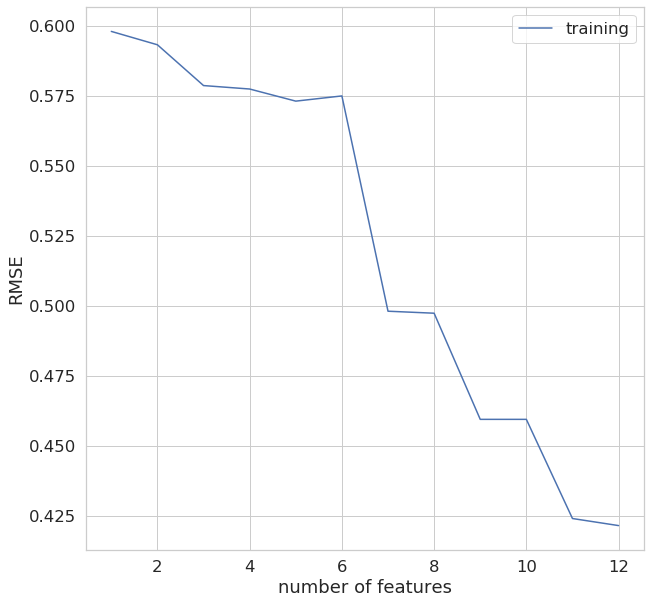

In [303]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

# Imported to avoid 85 warnings from showing
import warnings
warnings.filterwarnings('ignore') 

# Write your description (2-3 sentences) as a comment here:
# Apart from the accuracy score, I was relying on the RMSE score, to ensure that it decreased along with the accuracy.
# In doing so, I made sure that when I did my cross validation of 10 folds, the error was not significant, nor was overfitting 
# to my initial training set.
# Therefore, I was able to get a reltively close accuracy score on my test set.

# Write the code to generate your visualization here:

# from lab 07
train_error_vs_N = []
range_of_num_features = range(1, X_train.shape[1] + 1)

for N in range_of_num_features:
    X_train_first_N_features = X_train.iloc[:, :N]    
    
    model.fit(X_train_first_N_features, Y_train)
    train_error = rmse(Y_train, model.predict(X_train_first_N_features))
    train_error_vs_N.append(train_error)
    
plt.figure(figsize=(10,10))
plt.plot(range_of_num_features, train_error_vs_N)
plt.legend(["training"], loc=1)
plt.xlabel("number of features")
plt.ylabel("RMSE");

# Note: if your plot doesn't appear in the PDF, you should try uncommenting the following line:
# plt.show()

As we can see, so far as we add more features our rmse keeps decreasing

In [304]:
X_test = X_test.drop(["Batting", "Details", "Date", "Name", "AB", "R", "BB", "SO", "PO", "A", "RBI", "PA", "Pit", "Str"], axis=1)
model.fit(X_test,Y_test)

test_accuracy = model.score(X_test,Y_test)
print("Test Accuracy: ", test_accuracy)

Test Accuracy:  0.821656050955414


Lets take another approach

On the reasearch paper, the following stats were used:
    1. Average number of hits per game, last 30 games
    2. Average hits pre game, lst 3 games
    3. Average number of at bats, last 10 games
    4. Ballpark preference
    5. & 6. depend on information about the pitcher
   

In [60]:
#nyy19["mean of hits"] = [np.mean(nyy19[nyy19["Name"]==s]["H"])for s in nyy19["Name"]]
#nyy19[nyy19["Name"]== 'Aaron Judge']

newlook = nyy19.groupby("Name").rolling(1).mean()
newlook.head(58)

Game  BatPos   AB    R    H  RBI   BB   SO   PA     BA  \
Name                                                                        
Aaron Hicks 438    41.0     2.0  4.0  0.0  0.0  0.0  0.0  3.0  4.0  0.000   
            448    42.0     1.0  4.0  0.0  0.0  0.0  0.0  1.0  4.0  0.000   
            460    43.0     3.0  5.0  0.0  2.0  0.0  0.0  2.0  5.0  0.154   
            470    44.0     1.0  3.0  2.0  1.0  2.0  2.0  2.0  5.0  0.188   
            482    45.0     1.0  3.0  1.0  0.0  1.0  1.0  1.0  5.0  0.158   
            495    46.0     4.0  3.0  2.0  1.0  0.0  2.0  0.0  5.0  0.182   
            513    48.0     1.0  4.0  0.0  1.0  1.0  1.0  1.0  5.0  0.192   
            524    49.0     0.0  4.0  2.0  1.0  0.0  1.0  2.0  5.0  0.200   
            546    51.0     3.0  5.0  1.0  1.0  2.0  0.0  2.0  5.0  0.200   
            557    52.0     2.0  4.0  0.0  0.0  0.0  0.0  1.0  4.0  0.179   
            568    53.0     2.0  4.0  0.0  2.0  1.0  0.0  0.0  4.0  0.209   
            589    55.0     2.0  3.0  0.0  1.0  2.0  1.0  2.0  4.0  0.217   
            599    56.0     2.0  4.0  0.0  0.0  0.0  0.0  0.0  4.0  0.200   
            611    57.0     3.0  4.0  0.0  1.0  1.0  0.0  0.0  4.0  0.204   
            622    58.0     3.0  4.0  2.0  2.0  1.0  1.0  1.0  5.0  0.224   
            640    60.0     1.0  5.0  1.0  2.0  3.0  0.0  1.0  5.0  0.238   
            650    61.0     1.0  4.0  1.0  1.0  1.0  0.0  0.0  4.0  0.239   
            661    62.0     2.0  3.0  0.0  0.0  0.0  1.0  0.0  4.0  0.229   
            671    63.0     1.0  5.0  0.0  1.0  1.0  1.0  2.0  6.0  0.227   
            682    64.0     1.0  4.0  1.0  1.0  0.0  1.0  0.0  5.0  0.228   
            703    66.0     1.0  4.0  0.0  0.0  0.0  0.0  2.0  4.0  0.217   
            715    67.0     2.0  3.0  0.0  0.0  0.0  1.0  0.0  4.0  0.209   
            727    68.0     2.0  4.0  1.0  1.0  0.0  1.0  2.0  5.0  0.211   
            747    70.0     2.0  4.0  0.0  1.0  0.0  0.0  1.0  4.0  0.213   
            757    71.0     2.0  4.0  0.0  0.0  0.0  0.0  2.0  4.0  0.204   
            770    72.0     5.0  3.0  2.0  0.0  0.0  1.0  0.0  4.0  0.198   
            795    74.0     9.0  2.0  0.0  0.0  0.0  0.0  1.0  2.0  0.194   
            802    75.0     6.0  3.0  1.0  1.0  0.0  1.0  2.0  4.0  0.198   
            814    76.0     7.0  3.0  1.0  1.0  0.0  0.0  1.0  3.0  0.202   
            819    77.0     2.0  4.0  2.0  1.0  3.0  1.0  2.0  5.0  0.204   
            834    78.0     7.0  4.0  0.0  1.0  0.0  0.0  1.0  4.0  0.205   
            844    79.0     6.0  2.0  1.0  0.0  1.0  2.0  1.0  5.0  0.202   
            857    80.0     9.0  5.0  2.0  2.0  2.0  0.0  1.0  5.0  0.210   
            864    81.0     3.0  5.0  1.0  2.0  2.0  0.0  1.0  6.0  0.217   
            874    82.0     2.0  3.0  0.0  1.0  0.0  1.0  2.0  4.0  0.220   
            885    83.0     3.0  4.0  0.0  1.0  0.0  1.0  1.0  5.0  0.221   
            894    84.0     1.0  4.0  0.0  1.0  1.0  1.0  1.0  5.0  0.221   
            913    85.0    10.0  2.0  1.0  1.0  1.0  0.0  0.0  2.0  0.225   
            917    86.0     2.0  5.0  1.0  3.0  2.0  0.0  1.0  5.0  0.238   
            925    87.0     0.0  3.0  0.0  0.0  0.0  1.0  3.0  4.0  0.233   
            937    88.0     2.0  4.0  1.0  2.0  0.0  0.0  1.0  4.0  0.240   
            951    89.0     6.0  3.0  1.0  0.0  0.0  1.0  1.0  4.0  0.236   
            969    91.0     4.0  4.0  1.0  2.0  0.0  0.0  1.0  4.0  0.242   
            981    92.0     7.0  4.0  0.0  0.0  0.0  0.0  0.0  4.0  0.236   
            987    93.0     2.0  4.0  2.0  2.0  1.0  0.0  1.0  4.0  0.243   
            1009   95.0     4.0  4.0  0.0  2.0  0.0  0.0  2.0  4.0  0.249   
            1018   96.0     3.0  4.0  1.0  1.0  1.0  1.0  2.0  5.0  0.249   
            1029   97.0     2.0  3.0  1.0  1.0  2.0  1.0  1.0  4.0  0.250   
            1041   98.0     5.0  5.0  0.0  0.0  0.0  0.0  3.0  5.0  0.243   
            1047   99.0     0.0  5.0  2.0  2.0  2.0  1.0  1.0  6.0  0.247   
            106